In [4]:
import numpy as np
import pandas as pd

import torch.nn as nn
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

from matplotlib import pyplot as plt
import plotly.express as px

import torchvision.datasets as datasets
from torch.utils.data import ConcatDataset
import torchvision.transforms as transforms

from sklearn.preprocessing import StandardScaler,LabelEncoder
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix

from tqdm import tqdm

c:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Common transform to convert PIL image to tensor
transform = transforms.ToTensor()

# Fashion MNIST
full_fashion = ConcatDataset([
    datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform),
    datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
])

# Digit MNIST
full_mnist = ConcatDataset([
    datasets.MNIST(root='./data', train=True, download=True, transform=transform),
    datasets.MNIST(root='./data', train=False, download=True, transform=transform)
])

def dataset_to_numpy(dataset):
    images = []
    labels = []
    for img, label in dataset:
        images.append(img.numpy())  # shape: (1, 28, 28)
        labels.append(label)
    return np.array(images), np.array(labels)

mnist, y_mnist = dataset_to_numpy(full_mnist)
fashion, y_fashion = dataset_to_numpy(full_fashion)
mnist = mnist.reshape((mnist.shape[0], -1))
fashion = fashion.reshape((fashion.shape[0], -1))

scaled_data = StandardScaler().fit_transform(fashion)

In [8]:
scaled_data.shape

(70000, 784)

In [9]:
y_fashion.shape

(70000,)

#### PCA

Explained variance: [173.20604 112.91804]
Explained variance ratio: [0.22092292 0.14402606]


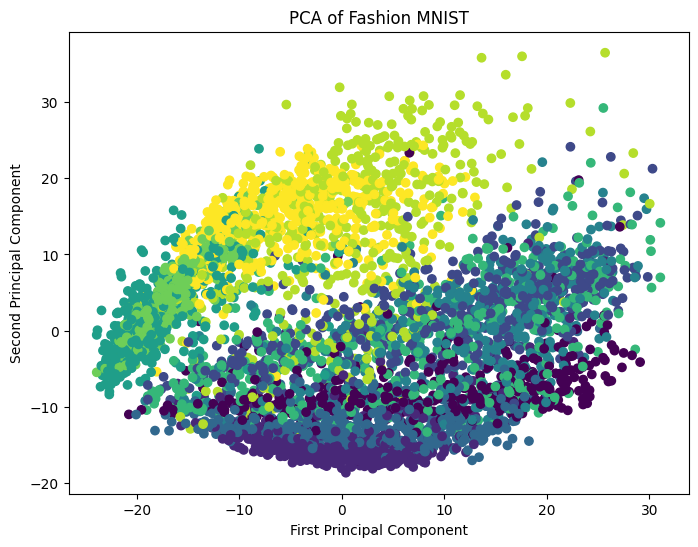

In [ ]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Create a DataFrame with the PCA result
#print(pca_result)

# Explained variance measures the absolute amount of variance that is explained by each principal component. 
# This is useful when you want to know how many principal components you need to retain in order to capture a 
# certain percentage of the total variance in the original dataset.
print("Explained variance:", pca.explained_variance_)

# Explained variance ratio measures the relative amount of variance that is explained by each principal component. 
# This is useful when you want to know how much information each principal component
# contributes to the overall structure of the data.
print("Explained variance ratio:", pca.explained_variance_ratio_)


plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:5000, 0], 
            pca_result[:5000, 1],
            c=y_fashion[:5000],
            cmap='viridis')

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA of Fashion MNIST')
plt.show()

#### UMAP

c:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


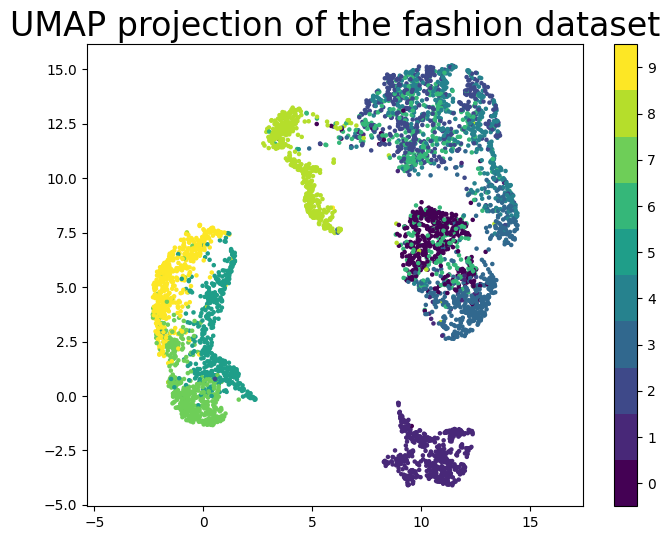

In [28]:
umap_enc = UMAP()
umap_result = umap_enc.fit_transform(scaled_data)

plt.figure(figsize=(8, 6))
plt.scatter(umap_result[:5000, 0], 
            umap_result[:5000, 1], 
            c=y_fashion[:5000], 
            cmap='viridis', s=5)

plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the fashion dataset', fontsize=24);

#### t-SNE

In [ ]:
tsne = TSNE(n_components=2,perplexity=40, random_state=42)
tsne_result = tsne.fit_transform(fashion[:5000])
tsne.kl_divergence_

1.2234996557235718

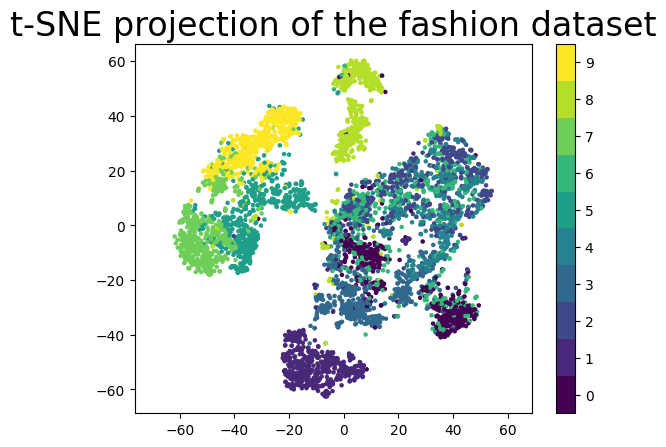

In [ ]:
plt.scatter(tsne_result[:5000, 0], tsne_result[:5000, 1], c=y_fashion[:5000], cmap='viridis', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('t-SNE projection of the fashion dataset', fontsize=24);

#### VAE

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
class Autoencoder(nn.Module):
    """
    This code is hevily inspired by Konstantin Sofeikovs' work: 
    https://medium.com/@sofeikov/implementing-variational-autoencoders-from-scratch-533782d8eb95
    """
    def __init__(self):
        super().__init__()
        self.encoder = None
        self.decoder = None
    # Create the encoder and decoder networks
    def build(self, input_dim):
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )
    # One full run through the network
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    
    def fit_transform(self, X):
        input_dim = X.shape[1]
        self.build(input_dim)
        X_tensor = torch.tensor(X, dtype=torch.float32)
        dataset = TensorDataset(X_tensor, X_tensor)
        dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        criterion = nn.MSELoss()

        for epoch in range(20):
            for xb, yb in dataloader:
                optimizer.zero_grad()
                recon = self(xb)
                loss = criterion(recon, yb)
                loss.backward()
                optimizer.step()
        
        with torch.no_grad():
            encoded = self.encoder(X_tensor).numpy()
        return encoded

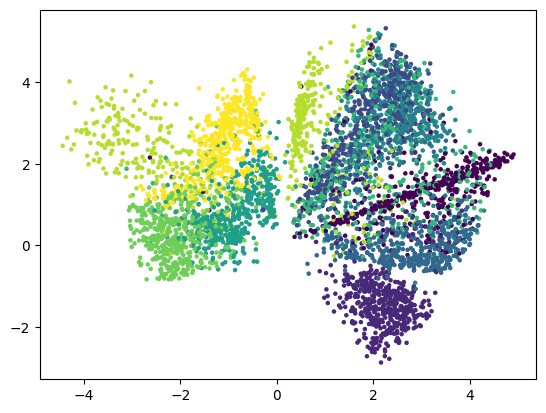

In [89]:
vae_result = Autoencoder().fit_transform(fashion[:5000])
plt.scatter(vae_result[:, 0], vae_result[:, 1], c=y_fashion[:5000], cmap='viridis', s=5)

#### Testing Dim Reduc Methods

In [ ]:
X = pca_result
y = y_fashion

sc = StandardScaler()

X = sc.fit_transform(X)
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

classifiers = [LinearDiscriminantAnalysis(), RandomForestClassifier(max_depth=5,random_state=42), GaussianNB()]
dim_reducers = [PCA(random_state=42), UMAP(random_state=42), Autoencoder()]
metrics = {'PCA': [],
           'UMAP': [],
           'TSNE': [],
           'Autoencoder': []}
keys = ['PCA', 'UMAP', 'Autoencoder']


for dim_red in tqdm(dim_reducers):
   X = dim_red.fit_transform(scaled_data)
   X = sc.fit_transform(X)
   for i in range(len(classifiers)+1):
      clf = classifiers[i]
      model = clf.fit(X, y_fashion)
      y_pred = model.predict(X)
      metrics[keys[i]].append(accuracy_score(y_fashion, y_pred))

 25%|██▌       | 1/4 [02:50<08:32, 170.77s/it]c:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
100%|██████████| 4/4 [17:48<00:00, 267.17s/it]


['PCA', 'UMAP', 'TSNE', 'Autoencoder']

In [91]:
metrics

{'PCA': [0.8299571428571428,
  0.7250142857142857,
  0.6529285714285714,
  0.6592857142857143],
 'UMAP': [0.7561285714285715, 0.7421571428571428, 0.7306, 0.7127142857142857],
 'TSNE': [0.5031857142857142,
  0.7227857142857143,
  0.6803285714285714,
  0.6211285714285715],
 'Autoencoder': []}

#### LDA

In [23]:
lda = LinearDiscriminantAnalysis()
#X_train = lda.fit_transform(X_train, y_train)
#X_test = lda.transform(X_test)
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
print("LDA accuracy:", accuracy_score(y_test, y_pred))

LDA accuracy: 0.4725714285714286


#### Classifying with Random Forest

In [ ]:
classifier = RandomForestClassifier(max_depth=4, random_state=42)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print('Accuracy : ' + str(accuracy_score(y_test, y_pred)))
conf_m = confusion_matrix(y_test, y_pred)
print(conf_m)

Accuracy : 0.5270714285714285
[[1028    4   47  114   86   18   64    1   16    2]
 [  65 1021    6  257   17    0    4    0    1    0]
 [ 118    0  353    2  631   26  213    1   65    1]
 [ 368  139    4  807   15    0   25    0    5    1]
 [ 269    0  212   31  695   15  109    0   34    0]
 [   5    0    7    0    1  603   40  644    7  148]
 [ 394    1  210   39  396   31  255    4   61    6]
 [   0    0    0    0    0  183    3 1081    2  207]
 [  85    0  126   10   35   12  105   54  593  373]
 [   1    0   16    0   21    7   10  140  251  943]]


#### Classifying with Naive Bayes

In [21]:
classifier = GaussianNB()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print('Accuracy : ' + str(accuracy_score(y_test, y_pred)))
conf_m = confusion_matrix(y_test, y_pred)
print(conf_m)

Accuracy : 0.4928571428571429
[[ 632   16   33  523  108   38   16    0   11    3]
 [  20 1182    4  142   18    3    2    0    0    0]
 [ 146    0  383   13  555   99  166    2   44    2]
 [ 146  456    4  727   18    6    3    0    3    1]
 [ 227    4  259  111  631   39   77    0   17    0]
 [   7    0    8    0    0  788    6  538    7  101]
 [ 287    3  179  198  409  121  143    8   40    9]
 [   0    0    1    0    0  377    0  932    0  166]
 [  79    3  142   38   29   37   81   77  512  395]
 [   3    0   25    1   15   16    5  161  193  970]]
